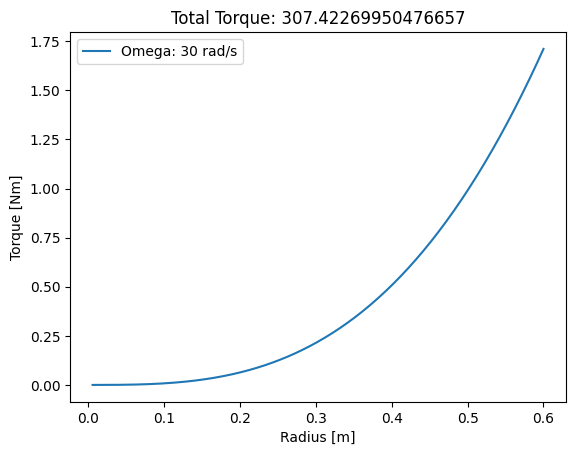

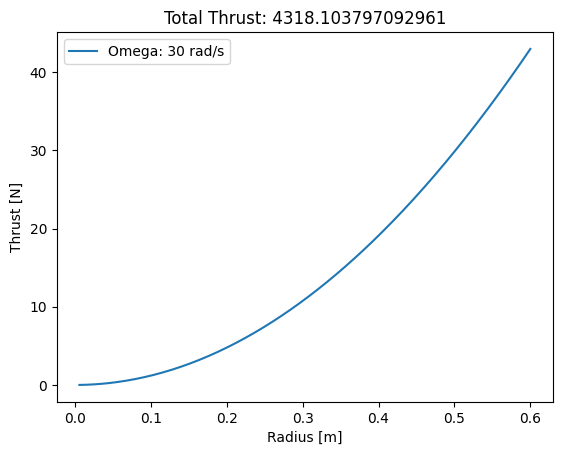

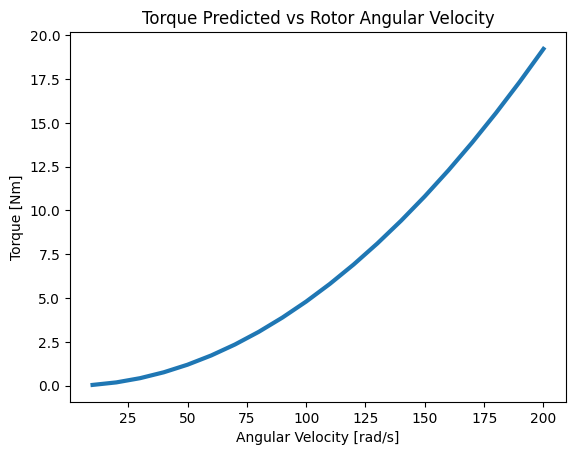

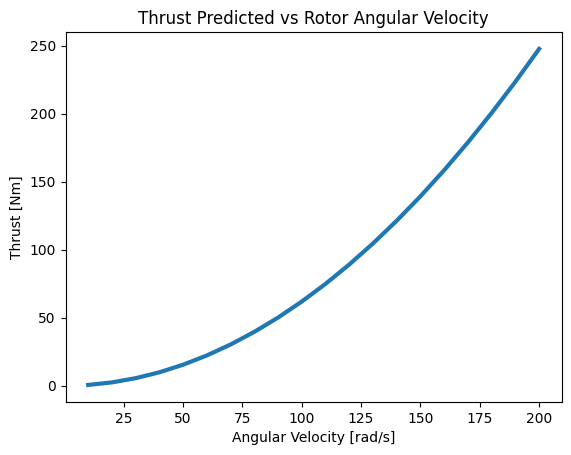

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

def Cl(alpha):
    return 3./25 * alpha + 0.6

def Cd(alpha):
    return 3.8e-4 * alpha**2 + 0.02

def Thrust(Cl, rho, omega, r, c, phi, Cd, B, V0, dr_segment):
    V1 = np.sqrt((omega * r)**2 + V0**2)
    return 0.5 * rho * V1**2 * (Cl * np.cos(np.radians(phi)) - Cd * np.sin(np.radians(phi))) * B * c * dr_segment

def Torque(Cl, rho, omega, r, c, phi, Cd, B, V0, dr_segment):
    V1 = np.sqrt((omega * r)**2 + V0**2)
    return 0.5 * rho * V1**2 * (Cd * np.cos(np.radians(phi)) + Cl * np.sin(np.radians(phi))) * B * c * dr_segment * r

def NACA_f(x, t):
    return 5 * t * (0.2969 * np.sqrt(x) - 0.126 * x - 0.3156 * x**2 + 0.2843 * x**3 - 0.1015 * x**4)

def dr(c, t):
    area_of_NACA, _ = quad(NACA_f, 0, c, args=(t,))
    return 2 * area_of_NACA

def Omega_Estimate(Cl, rho, total_drag, c, phi, Cd, B, V0, L):
    V1_squared = 2 * total_drag / (rho * (Cd * np.cos(np.radians(phi)) + Cl * np.sin(np.radians(phi))) * B * c * L**2)
    return np.sqrt(V1_squared - V0**2) / L

def Omega_Thrust_Estimate(Cl, rho, total_thrust, c, phi, Cd, B, V0, L, omega):
    V1_squared = 2 * total_thrust / (rho * (Cl * np.cos(np.radians(phi)) - Cd * np.sin(np.radians(phi))) * B * c * L)
    if V1_squared < V0**2:
        return 2 * omega
    else:
        return np.sqrt(V1_squared - V0**2) / L


# Constants
theta = 6
alpha = 6
rho = 1.225

R = 0.6    # Rotor Radius
c = 0.15   # Rotor Chord
V1 = 0

B = 2      # Number of blades
segments = 300
r_seg = np.linspace(0, R, segments + 1)

torque_profile = np.zeros(len(r_seg))
thrust_profile = np.zeros(len(r_seg))
V0 = np.zeros(len(r_seg))
F = 0.05
iterations = 25  # Number of iterations for the V01
torque_P = np.zeros((iterations, len(r_seg)))
thrust_P = np.zeros((iterations, len(r_seg)))
vortex_strength = np.zeros((iterations, len(r_seg)))
vortex_tangential_velocity = np.zeros(len(r_seg))
total_torque = 0
Torque_thrust = F * R * 2
torque_speed_curve = np.zeros(80)
thrust_speed_curve = np.zeros(80)


# Main loop
for x in range(10, 810, 10):  # For loop to get thrust produced for different omega values
    omega = x
    thrust_profile = np.zeros(len(r_seg))
    V02 = 0
    
    for j in range(iterations):
        alpha = theta - np.degrees(np.arctan(V02 / (2./3. * R * omega)))
        
        for i in range(len(r_seg)):
            thrust_profile[i] = Thrust(Cl(alpha), rho, omega, r_seg[i], c, theta - alpha, Cd(alpha), B, V0[i], R / segments)
            torque_profile[i] = Torque(Cl(alpha), rho, omega, r_seg[i], c, theta - alpha, Cd(alpha), B, V0[i], R / segments)
            thrust_P[j, i] = thrust_profile[i]
            torque_P[j, i] = torque_profile[i]
        
        total_thrust = np.sum(thrust_profile[3:])
        total_torque = np.sum(torque_profile[3:])
        CT = total_thrust / (np.pi * R**2 * rho * (omega * R)**2)
        tip_loss = 1 - np.sqrt(2 * CT) / 2
        V02 = np.sqrt(total_thrust * tip_loss / (np.pi * R**2 * rho * 2))
    
    torque_speed_curve[x // 10 - 1] = total_torque
    thrust_speed_curve[x // 10 - 1] = total_thrust * tip_loss

# Plotting
plt.figure()
plt.plot(r_seg[3:], torque_P[0, 3:], linewidth=1.5)
plt.xlabel('Radius [m]')
plt.ylabel('Torque [Nm]')
plt.title(f'Total Torque: {total_torque}')
plt.legend(["Omega: 30 rad/s"])
plt.show()

plt.figure()
plt.plot(r_seg[3:], thrust_P[-1, 3:], linewidth=1.5)
plt.xlabel('Radius [m]')
plt.ylabel('Thrust [N]')
plt.title(f'Total Thrust: {total_thrust}')
plt.legend(["Omega: 30 rad/s"])
plt.show()

plt.figure()
plt.plot(np.arange(10, 210, 10), torque_speed_curve[:20], linewidth=3)
plt.title("Torque Predicted vs Rotor Angular Velocity")
plt.xlabel('Angular Velocity [rad/s]')
plt.ylabel('Torque [Nm]')
plt.show()

plt.figure()
plt.plot(np.arange(10, 210, 10), thrust_speed_curve[:20], linewidth=3)
plt.title("Thrust Predicted vs Rotor Angular Velocity")
plt.xlabel('Angular Velocity [rad/s]')
plt.ylabel('Thrust [Nm]')
plt.show()

C:\Users\Rayde Kruger\AppData\Local\Temp\ipykernel_61548\3270512643.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


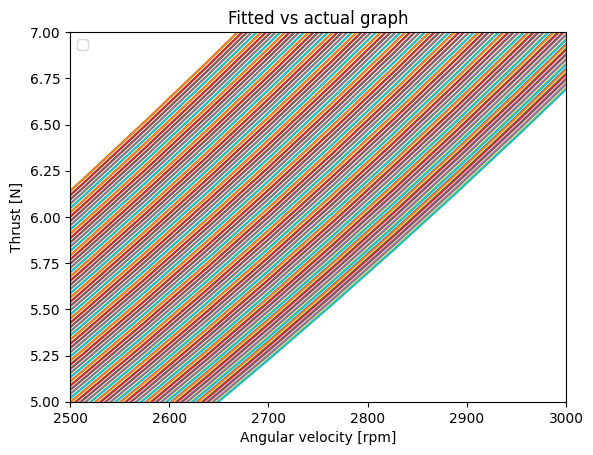

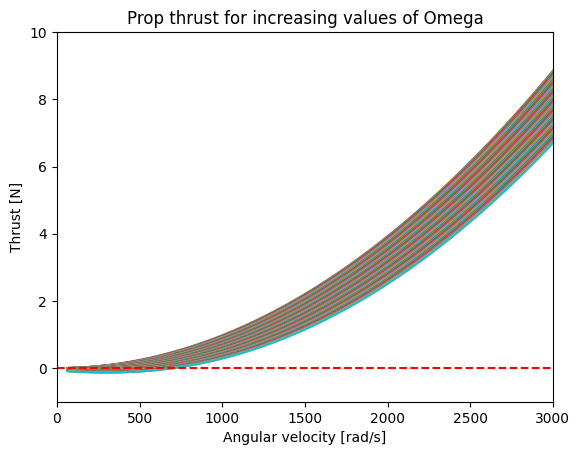

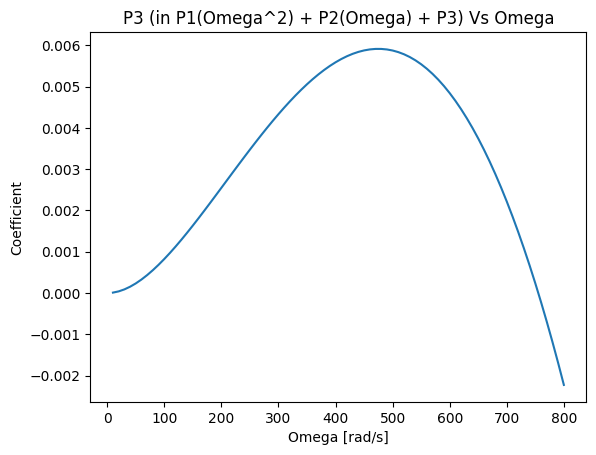

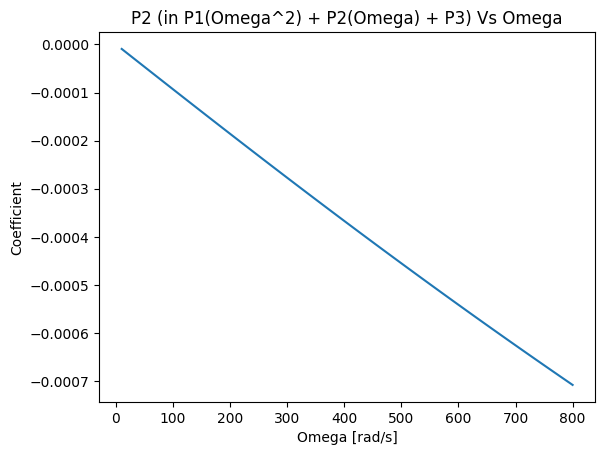

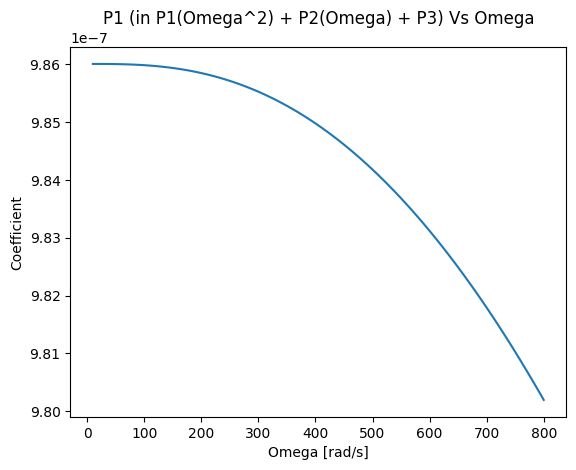

In [11]:
# Constants
Prop_radius = 2.9 / 2 * 0.0254
pitch = 0.0254 * 2.9
nr_of_blades = 4
pitch_angle = np.degrees(np.arctan(pitch / (2 * Prop_radius * np.pi)))
speed = 800  # Iterates between start and speed of omega values
prop_thrust_profile = np.zeros(speed // 10)
prop_torque_profile = np.zeros(speed // 10)
prop_Thrust_p1_coefficient = np.zeros(speed // 10)
prop_Thrust_p2_coefficient = np.zeros(speed // 10)
prop_Thrust_p3_coefficient = np.zeros(speed // 10)
all_thrust_profiles = np.zeros((speed // 10, speed // 10))
all_torque_profiles = np.zeros((speed // 10, speed // 10))
Position = 0.245
start = 10
xx = np.arange(start, speed + 1, 10) * 2 * np.pi

X = np.arange(start, speed + 1, 10) * 60

all_prop_thrust_profiles = []

for Omega_Speed in range(start, speed + 1, 10):
    for Prop_speeds in range(start, speed + 1, 10):
        V0_prop = Omega_Speed * Prop_radius * Position
        Omega_prop = Prop_speeds * 60 * np.pi / 30  # Converts speed to have a max of 48,000 rpm then into rad/s
        chord_of_prop = 0.01  # 1 cm wide props

        phi_prop = np.degrees(np.arctan(V0_prop / (2./3 * Prop_radius * Omega_prop)))
        alpha_prop = pitch_angle - phi_prop
        thrust_from_prop = Thrust(Cl(alpha_prop), rho, Omega_prop, 2/3 * Prop_radius, chord_of_prop, phi_prop, Cd(alpha_prop), nr_of_blades, V0_prop, 2/3 * Prop_radius)
        torque_of_prop = Torque(Cl(alpha_prop), rho, Omega_prop, 2/3 * Prop_radius, chord_of_prop, phi_prop, Cd(alpha_prop), nr_of_blades, V0_prop, 2/3 * Prop_radius)
        
        prop_thrust_profile[Prop_speeds // 10 - 1] = thrust_from_prop
        prop_torque_profile[Prop_speeds // 10 - 1] = torque_of_prop
        all_thrust_profiles[Omega_Speed // 10 - 1, Prop_speeds // 10 - 1] = thrust_from_prop
        all_torque_profiles[Omega_Speed // 10 - 1, Prop_speeds // 10 - 1] = torque_of_prop
    
    # Append current thrust profile to all_prop_thrust_profiles for later plotting
    all_prop_thrust_profiles.append(prop_thrust_profile.copy())

    p = np.polyfit(xx, prop_thrust_profile, 2)
    prop_Thrust_p1_coefficient[Omega_Speed // 10 - 1] = p[0]
    prop_Thrust_p2_coefficient[Omega_Speed // 10 - 1] = p[1]
    prop_Thrust_p3_coefficient[Omega_Speed // 10 - 1] = p[2]

    Y = np.polyval(p, xx)
    plt.plot(xx, Y)
    plt.plot(np.arange(start, speed + 1, 10) * 60 * np.pi / 30, prop_thrust_profile)
    plt.ylim([5, 7])
    plt.xlim([2500, 3000])

plt.xlabel('Angular velocity [rpm]')
plt.ylabel('Thrust [N]')
plt.title('Fitted vs actual graph')
plt.legend()
plt.show()

# Plot all prop thrust profiles on one graph
plt.figure()
for profile in all_prop_thrust_profiles:
    plt.plot(np.arange(start, speed + 1, 10) * 60 * np.pi / 30, profile)

plt.xlabel('Angular velocity [rad/s]')
plt.ylabel('Thrust [N]')
plt.title('Prop thrust for increasing values of Omega')
plt.axhline(0, linestyle='--', color='r', linewidth=1.5)
plt.axvline(3351, linestyle='--', color='b', linewidth=1.5)
plt.ylim([-1, 10])
plt.xlim([0, 3000])
plt.show()

plt.plot(np.arange(start, speed + 1, 10), prop_Thrust_p3_coefficient, linewidth=1.5)
plt.xlabel('Omega [rad/s]')
plt.ylabel('Coefficient')
plt.title('P3 (in P1(Omega^2) + P2(Omega) + P3) Vs Omega')
plt.show()

plt.plot(np.arange(start, speed + 1, 10), prop_Thrust_p2_coefficient, linewidth=1.5)
plt.xlabel('Omega [rad/s]')
plt.ylabel('Coefficient')
plt.title('P2 (in P1(Omega^2) + P2(Omega) + P3) Vs Omega')
plt.show()

plt.plot(np.arange(start, speed + 1, 10), prop_Thrust_p1_coefficient, linewidth=1.5)
plt.xlabel('Omega [rad/s]')
plt.ylabel('Coefficient')
plt.title('P1 (in P1(Omega^2) + P2(Omega) + P3) Vs Omega')
plt.show()

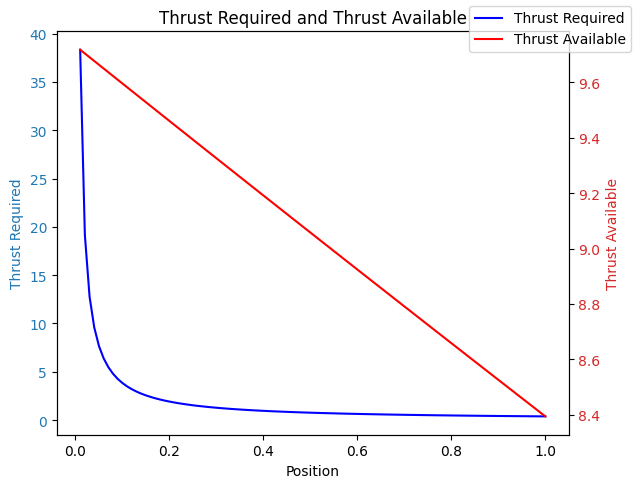

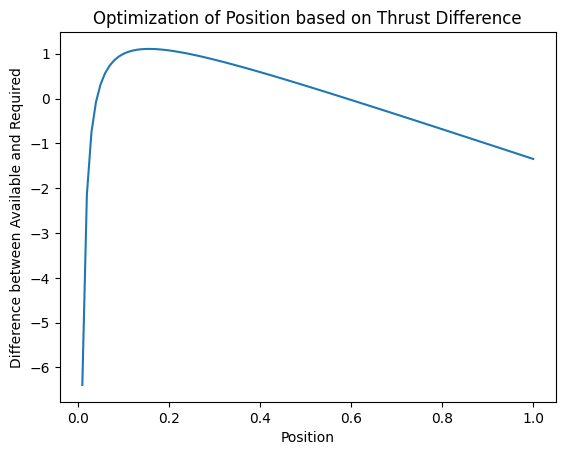

Optimum rotor ratio is at 0.155 of the rotor
For a rotor size of 0.04 m, the thrust should be placed at 0.006 m


In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
Prop_radius = 2.9 / 2 * 0.0254
pitch = 0.0254 * 2.9
nr_of_blades = 4
pitch_angle = np.degrees(np.arctan(pitch / (2 * Prop_radius * np.pi)))
chord_of_prop = 0.01  # 1 cm wide props
Torque_required = 0.08
Omega = 40
hub_radius = 135 / 2000
Omega_prop = 500 * 60 * np.pi / 30  # Converts speed to have a max of 48,000 rpm then into rad/s
Start = 0.01
R = Prop_radius

# Define Position array
Position = np.linspace(Start, 1, int((1 - Start) / 0.01) + 1)

# Arrays for thrust
Thrust_required = np.zeros(Position.size)
Thrust_available = np.zeros(Position.size)

def Cl(alpha):
    return 3./25 * alpha + 0.6

def Cd(alpha):
    return 3.8e-4 * alpha**2 + 0.02

def Thrust(Cl, rho, omega, r, c, phi, Cd, B, V0, dr_segment):
    V1 = np.sqrt((omega * r)**2 + V0**2)
    return 0.5 * rho * V1**2 * (Cl * np.cos(np.radians(phi)) - Cd * np.sin(np.radians(phi))) * B * c * dr_segment

# Constants
rho = 1.225  # Air density (kg/m^3)

# Loop to calculate thrust required and available
for idx, pos in enumerate(Position):
    V0_prop = Omega * (R + hub_radius) * pos
    phi_prop = np.degrees(np.arctan(V0_prop / (2 / 3 * Prop_radius * Omega_prop)))
    alpha_prop = pitch_angle - phi_prop
    thrust_from_prop = Thrust(Cl(alpha_prop), rho, Omega_prop, 2 / 3 * Prop_radius, chord_of_prop, phi_prop, Cd(alpha_prop), nr_of_blades, V0_prop, 2 / 3 * Prop_radius)
    Thrust_available[idx] = thrust_from_prop
    Thrust_required[idx] = Torque_required / (2 * (R + hub_radius) * pos)

# Plotting
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Position')
ax1.set_ylabel('Thrust Required', color=color)
ax1.plot(Position, Thrust_required, '-b')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Thrust Available', color=color)
ax2.plot(Position, Thrust_available, '-r')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Thrust Required and Thrust Available')
fig.legend(['Thrust Required', 'Thrust Available'], loc='upper right')

plt.show()

# Constants
Prop_radius = 2.9 / 2 * 0.0254
pitch = 0.0254 * 2.9
nr_of_blades = 4
pitch_angle = np.degrees(np.arctan(pitch / (2 * Prop_radius * np.pi)))
chord_of_prop = 0.01  # 1 cm wide props
Torque_required = 0.08
Omega = 40
hub_radius = 135 / 2000
Omega_prop = 500 * 60 * np.pi / 30  # Converts speed to have a max of 48,000 rpm then into rad/s
Start = 0.01
R = Prop_radius

# Define Position array
Position = np.linspace(Start, 1, int((1 - Start) / 0.01) + 1)

# Arrays for thrust
Thrust_required = np.zeros(Position.size)
Thrust_available = np.zeros(Position.size)

def Cl(alpha):
    return 3./25 * alpha + 0.6

def Cd(alpha):
    return 3.8e-4 * alpha**2 + 0.02

def Thrust(Cl, rho, omega, r, c, phi, Cd, B, V0, dr_segment):
    V1 = np.sqrt((omega * r)**2 + V0**2)
    return 0.5 * rho * V1**2 * (Cl * np.cos(np.radians(phi)) - Cd * np.sin(np.radians(phi))) * B * c * dr_segment

# Constants
rho = 1.225  # Air density (kg/m^3)

# Loop to calculate thrust required and available
for idx, pos in enumerate(Position):
    V0_prop = Omega * (R + hub_radius) * pos
    phi_prop = np.degrees(np.arctan(V0_prop / (2 / 3 * Prop_radius * Omega_prop)))
    alpha_prop = pitch_angle - phi_prop
    thrust_from_prop = Thrust(Cl(alpha_prop), rho, Omega_prop, 2 / 3 * Prop_radius, chord_of_prop, phi_prop, Cd(alpha_prop), nr_of_blades, V0_prop, 2 / 3 * Prop_radius)
    Thrust_available[idx] = thrust_from_prop
    Thrust_required[idx] = Torque_required / (2 * (R + hub_radius) * pos)

# Standardize thrust values
Thrust_available_standardized = (Thrust_available - np.mean(Thrust_available)) / np.std(Thrust_available)
Thrust_required_standardized = (Thrust_required - np.mean(Thrust_required)) / np.std(Thrust_required)

# Calculate optimization curve and gradient
optimisation_curve = Thrust_available_standardized - Thrust_required_standardized
gradient = np.diff(optimisation_curve)

# Find the minimum gradient and corresponding position
grad_min_index = np.argmin(np.abs(gradient))
Optimum_position = ((grad_min_index + 0.5) * 0.01 + Start) * R

# Plot optimization curve
plt.figure()
plt.plot(Position, optimisation_curve)
plt.title('Optimization of Position based on Thrust Difference')
plt.xlabel('Position')
plt.ylabel('Difference between Available and Required')
plt.show()

# Output the result
print(f'Optimum rotor ratio is at {Optimum_position / R:.3f} of the rotor')
print(f'For a rotor size of {R:.2f} m, the thrust should be placed at {Optimum_position:.3f} m')


np.float64(-0.0007079595821800198)